In [1]:
# Forked and modified from https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

from __future__ import (absolute_import, division, print_function)

import collections
import math
import os
import random
import zipfile
import re

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Done")

Done


In [25]:
import pandas
import nltk

#TODO(remove other errors, spelling mistakes, urls etc.)
#Pipes and stars.
#TODO Preprocessing and cleaning of text data
# Split concatenated words http://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
def get_full_text_description(data_column):
  pattern = re.compile(r'(\w+)\/(\w+)')
  cleaned_text = ''  
  for cell in data_column:
    if pattern.search(cell):
      cell = pattern.sub(r'\1 \2', cell)
    cleaned_text += cell.lower() + ' '
  tokens = nltk.word_tokenize(cleaned_text)
  text = nltk.Text(tokens)
  return text

In [64]:
data = pandas.read_csv('data/train.csv')#, nrows=50000) #Can read a subset. First nrows of the total.
words = get_full_text_description(data['FullDescriptionWithTitle'])
print(words[0:100])

['engineering', 'systems', 'analyst', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'our', 'client', 'is', 'located', 'in', 'dorking', ',', 'surrey', 'and', 'are', 'looking', 'for', 'engineering', 'systems', 'analyst', 'our', 'client', 'provides', 'specialist', 'software', 'development', 'keywords', 'mathematical', 'modelling', ',', 'risk', 'analysis', ',', 'system', 'modelling', ',', 'optimisation', ',', 'miser', ',', 'pioneeer', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'engineering', 'systems', 'analyst', 'mathematical', 'modeller', 'engineering', 'systems', 'analyst', '/', 'mathematical', 'modeller', '.', 'our', 'client', 'is', 'a', 'highly', 'successful', 'and', 'respected', 'consultancy', 'providing', 'specialist', 'software', 'development', 'miser', ',', 'pioneer', ',', 'maths', ',', 'mathematical', ',', 'optimisation', ',', 'risk', 'analysis', ',', 'asset', 'management', ',', 'water', 'industry', ',', 'access', '

In [65]:
total_unique_words = len(set(words)) 
print("Total unique words = %s" % total_unique_words)

Total unique words = 207244


In [66]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 100000

def build_dataset(words):
  count = [['UNK', -1]]
  word_counter = collections.Counter(words).most_common(vocabulary_size - 1)
  count.extend(word_counter)
  dictionary = dict()
  for word, _ in count:
    # Indexing words by their rank in terms of frequency.
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  count[0] = (count[0][0], count[0][1])
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
#del words  # Hint to reduce memory requirements.

In [69]:
print('Most common words (+UNK)', count[:25])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
#Generate metadata tsv that maps words to counts. Used for tensorboard.
metadata = pandas.DataFrame(count, columns=["Word", "Frequency"])
print(metadata)
metadata.to_csv("data/word_frequency.tsv", sep="\t", index=False)
#TODO Finish setting up metadata with model.

Most common words (+UNK) [('UNK', 107245), ('and', 1861019), (',', 1617487), ('.', 1481527), ('the', 1454464), ('to', 1412691), ('a', 1061525), ('of', 1000037), ('in', 725341), ('for', 607247), ('with', 510193), ('you', 477721), ('will', 457458), ('be', 437655), ('is', 420887), ('this', 346911), ('****', 345136), ('as', 330372), ('an', 309967), (':', 300754), ('are', 300326), ('experience', 298770), ('on', 276909), ('have', 253099), ('or', 229940)]
Sample data [128, 109, 264, 128, 109, 264, 7625, 985, 83, 162] ['engineering', 'systems', 'analyst', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k']
                                                    Word  Frequency
0                                                    UNK     107245
1                                                    and    1861019
2                                                      ,    1617487
3                                                      .    1481527
4                            

In [31]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

115 systems -> 250 analyst
115 systems -> 153 engineering
250 analyst -> 115 systems
250 analyst -> 153 engineering
153 engineering -> 250 analyst
153 engineering -> 115 systems
115 systems -> 153 engineering
115 systems -> 250 analyst


In [34]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 256  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 1.0

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='word_embedding')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, 
                     num_sampled, vocabulary_size))

  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

In [55]:
import time

# Step 5: Begin training.
num_steps = 1000001

evaluation_interval_size = 5000

log_dir = "logs"

# Note that this is expensive (~20% slowdown if computed every 500 steps)
printout_frequency = 100000

#TODO Add snapshotting
checkpoint_frequency = 25000
checkpoint_folder = "model_checkpoints"

ckpt = tf.train.get_checkpoint_state(checkpoint_folder)                                     
assert ckpt, "No checkpoint found"                                                       
assert ckpt.model_checkpoint_path, "No model path found in checkpoint"

restore_from_model = True

with tf.Session(graph=graph) as session:
  summaries = tf.summary.merge_all()                                                       
  writer = tf.summary.FileWriter(                                                          
      os.path.join(log_dir, time.strftime("%Y-%m-%d-%H-%M-%S")))                  
  writer.add_graph(session.graph)                                                             
                                                                                                  
  session.run(tf.global_variables_initializer())
  saver = tf.train.Saver(tf.global_variables()) 
    
  # We must initialize all variables before we use them.
  #init.run()
  #print("Initialized")
  if restore_from_model:
    saver.restore(session, ckpt.model_checkpoint_path)

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % evaluation_interval_size == 0:
      if step > 0:
        average_loss /= evaluation_interval_size
      # The average loss is an estimate of the loss over the last n batches.
      print("Step %s: Loss %s" % (step, average_loss))
      average_loss = 0

    if step % printout_frequency == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to '%s':" % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s '%s'," % (log_str, close_word)
        print(log_str)
    
    if (step + 1) % checkpoint_frequency == 0:
        print("Saving at step: %s" % step)
        checkpoint_path = os.path.join(checkpoint_folder, 'word2vec_model%s.ckpt' % time.strftime("%Y-%m-%d-%H-%M-%S"))                  

        saver.save(session, checkpoint_path, global_step=step)
  final_embeddings = normalized_embeddings.eval()

INFO:tensorflow:Restoring parameters from model_checkpoints/word2vec_model2017-05-30-21-42-55.ckpt-24999
Step 0: Loss 4.4883351326
Nearest to 'an': 'a', 'the', '?', 'UNK', 'abandonment',
Nearest to 'team': 'teams', 'staff', '?', 'department', 'organisation',
Nearest to 'their': 'your', 'the', 'our', 'its', 'a',
Nearest to 'required': 'needed', 'essential', 'necessary', '?', 'need',
Nearest to ',': '?', 'and', '.', ';', 'UNK',
Nearest to 'uk': 'world', 'village', 'approaches', 'etrack', 'industry',
Nearest to 'as': 'www.totaljobs.com', 'UNK', 'acting', '', '?',
Nearest to 'your': 'their', 'the', 'a', '?', 'our',
Nearest to 'management': 'manager', 'planning', '?', 'managing', 'audit',
Nearest to 'technical': 'it', 'financial', 'software', 'hr', 'project',
Nearest to 'of': ',', 'to', '?', 'in', 'and',
Nearest to 'is': 'are', 'has', 'be', '?', 'offers',
Nearest to 'recruitment': 'rnc', 'mess', 'toward', 'business', 'layman',
Nearest to 'be': 'are', 'is', 'have', '?', 'being',
Nearest to 

KeyboardInterrupt: 

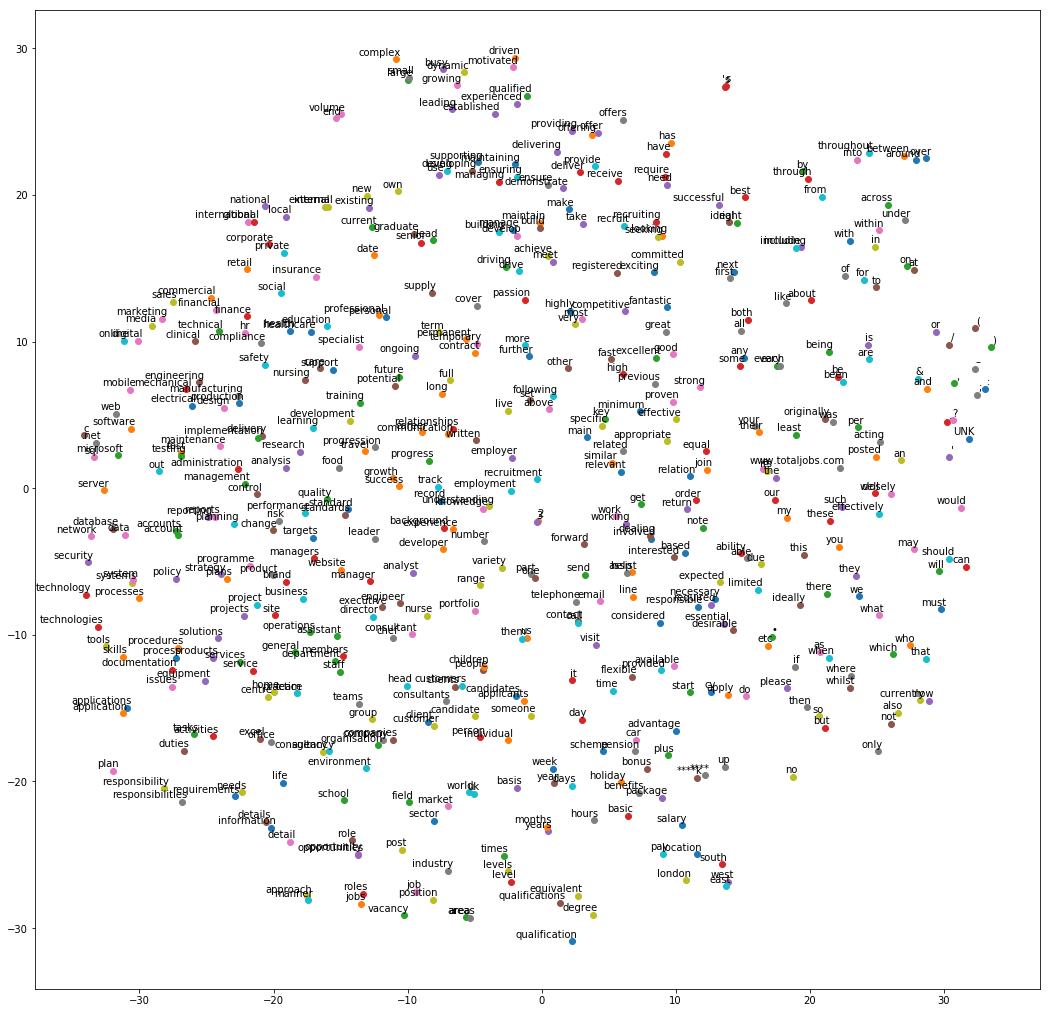

In [18]:
# Step 6: Visualize the embeddings.
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  #plt.show()
  plt.savefig(filename)

try:
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [36]:
print(final_embeddings.shape)
print(labels)
print(final_embeddings)

(25000, 128)
[[250]
 [153]
 [115]
 [153]
 [250]
 [115]
 [153]
 [250]]
[[-0.10473329  0.11549992 -0.11657206 ...,  0.11354174  0.03492368
  -0.11676676]
 [-0.14185616  0.08181372 -0.20268063 ..., -0.00533158  0.07613192
  -0.10321084]
 [-0.09985694  0.09777281 -0.03857588 ..., -0.07567087  0.05280143
  -0.08101523]
 ..., 
 [-0.13295303 -0.02048141 -0.1175654  ..., -0.11027188  0.10766811
  -0.08107989]
 [-0.0437792   0.13208513 -0.02985849 ...,  0.11260477  0.01630665
   0.10144638]
 [-0.0751639   0.05441151  0.03848866 ...,  0.04306783 -0.08177152
   0.03589645]]
